# CaloGAN

Generating calorimeter energy scans with dimensionality 8 voxels x 8 voxels x 2 channels (QDC and TDC) with a Generative Adversarial Network (GAN). 

# 0. Imports

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import time
import os

---
# 1. Setup

## 1.1. Load QDC and TDC from Text File

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events

In [4]:
def load_TQDC(finPath):
    basePath = "/media/sf_data/"

    # load data from file
    fin = os.path.join(basePath, finPath)
    t0 = time.time()
    raw_data = np.loadtxt(fin, skiprows = 5)
    t1 = time.time()
    print(f"Data file read in {t1-t0:.2f} seconds.")
    # return raw_data

    
    # initialize formatted data array
    num_events = raw_data.shape[0]
    print(f'There are {num_events} events')
    TDC = np.zeros((num_events, 8, 8), dtype=float)
    QDC = np.zeros((num_events, 8, 8), dtype=float)
    ogEventNums = np.zeros((num_events), dtype=int)
    
    
    # format data to [event#][x][y]
    t0 = time.time()
    i_event = -1

    
    for event in raw_data:
        i_event += 1 
        for x in range(8):
            # # this method preserves the original event number, but doesn't work when events aren't one by one
            # TDC [ np.int_(event[0]) ] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            # QDC [ np.int_(event[0]) ] [x] [:] = event[16*x+2 : 16*x+17 : 2]
            
            TDC [i_event] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            QDC [i_event] [x] [:] = event[16*x+2 : 16*x+17 : 2] 
            ogEventNums [i_event] = event[0]
            
    t1 = time.time()
    print(f"Data file formatted to array in {t1-t0:.2f} seconds.")
    
    return TDC, QDC, ogEventNums

In [5]:
base = r'C:\Users\zk117\Documents\00.local_WL-202\MUSE\data\calorimeter\elog_2341'

# fin = "run12130_calo_qdc_tdc_raw.txt" # First 100,000 (out of 1 mil) events, completely raw and unfiltered 
fin = r'run12130_calo_qdc_tdc_cut.txt' # BH electron PID cut + beam monitor hit cut

raw_data = load_TQDC(os.path.join(base, fin))

Data file read in 30.77 seconds.
There are 674056 events
Data file formatted to array in 8.68 seconds.


## 1.2. Event Display

In [7]:
colormap = 'magma'

def plotEvent(raw_data, event_num):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Plots an 8x8 histogram for the event
    '''
    
    TDC, QDC, ogEventNums = raw_data[:]
    
    ## 1. Plot Setup
    fig, (QAx, TAx) = plt.subplots(nrows=1, ncols=2, figsize= (13,5))#(11,4))
    plt.title(f'QDC for Event #{ogEventNums[event_num]}')

    ## 2. Plot QDC
    
    ## 2.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log10(np.where(QDC[event_num] <= 0, 0.01, QDC[event_num]))
    
    ## 2.2. Set flexible* max value for colorbar (*if the max qdc of this event is greater than the preset value, then use the actual max qdc value)
        # To cancel this effect, just set the preset value to be -1
                                                                                        # Format flexible vmax here
    presetMaxQDC = 3.5                                                                    
    if np.amax(thisFrame) > presetMaxQDC:
        this_vmax = np.amax(thisFrame)
    else:
        this_vmax = presetMaxQDC

    ## 2.3. Plot everything
    
    QPlot = QAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=this_vmax) # make sure to transpose frame for imshow
    
    QAx.set_title(f'QDC for Event #{ogEventNums[event_num]}')
    QAx.invert_yaxis()
    QAx.set_xticks(np.arange(0,8))
    Qcbar = plt.colorbar(QPlot, ax=QAx)
    Qcbar.set_label(r'QDC Counts ($\log_{10}$)', y=0.75)
    QAx.set_xlabel('X-coordinate of Bar')
    QAx.set_ylabel('Y-coordinate of Bar')
    # cbar.ax.tick_params()
   
    ## 2.4. Show QDC values in each square
    for x in range(8):
        for y in range(8):
            text = QAx.text(x, y, round(QDC[event_num][x][y],1), ha='center', va='center', color='w')
    
    ## 3. Plot TDC
    
    ## 3.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log(np.where(TDC[event_num] <= 0, 0.01, TDC[event_num]))
    
    ## 3.2. Plot everything 
    
    TPlot = TAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=4) # make sure to transpose frame for imshow
    
    TAx.set_title(f'TDC for Event #{ogEventNums[event_num]}')
    TAx.invert_yaxis()
    TAx.set_xticks(np.arange(0,8))
    Tcbar = plt.colorbar(TPlot, ax=TAx)
    Tcbar.set_label(r'TDC Counts ($\log_{10}$)', y=0.75)
    TAx.set_xlabel('X-coordinate of Bar')
    TAx.set_ylabel('Y-coordinate of Bar')
    
    ## 3.3. Show TDC values in each square
    for x in range(8):
        for y in range(8):
            if TDC[event_num][x][y] > 0.1:
                text = TAx.text(x, y, round(TDC[event_num][x][y],1), ha='center', va='center', color='w')

    
    fig.tight_layout()
    plt.show()
    return

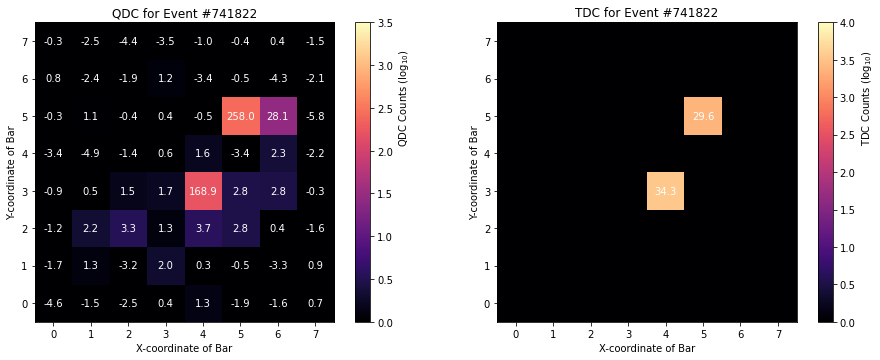

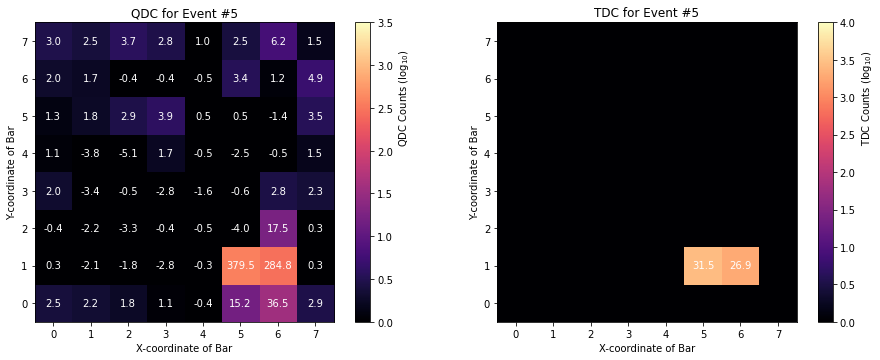

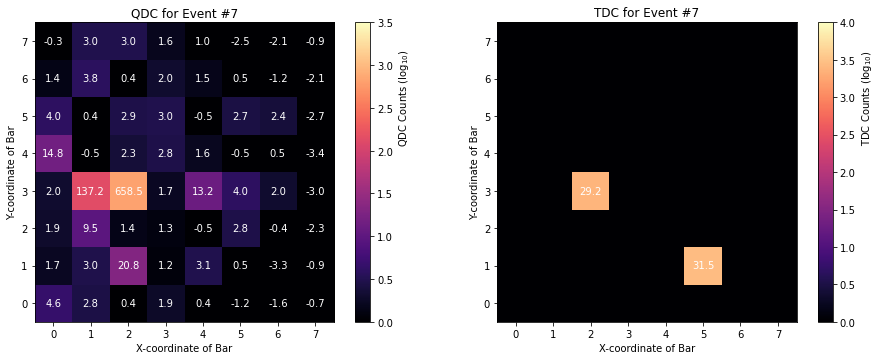

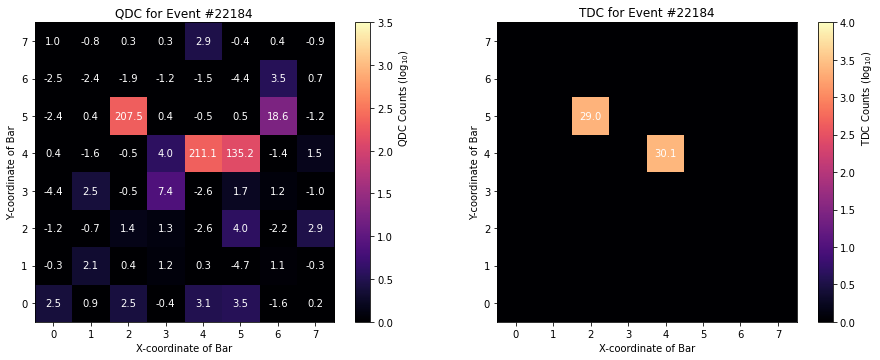

In [8]:
targets = [741822,5,7,22184,]#88965,1768,2935,3219,3944,4394,4548,7070]

for target in targets:
    event_num = np.where(raw_data[2]==target)[0][0]
    plotEvent(raw_data, event_num)

# for event_num in range(4000,5000,100):
#     plotEvent(raw_data, event_num)M

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events## 2.1. Helper Functions

---
# 2. GAN

In [49]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
# from tqdm.notebook import tqdm

torch.manual_seed(42)

## Normalize/Load Data on GPU

In [50]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce GTX 1050


In [51]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = get_default_device()

QTDC = np.asarray(raw_data[1::-1])
QTDC = np.transpose(QTDC, (1,0,2,3))
# QTDC[:, 1] = np.where(QTDC[:, 1] <= 0, 0, QTDC[:, 1]) # reaplce null TDC (-1000) with 0

# NORMALIZATION SCHEME:

# QTDC: <= 0 --> 0.001
QTDC = np.where(QTDC<=0, 0.001, QTDC)
# QTDC: all --> log10
QTDC = np.log10(QTDC)
# QTDC: < 0 --> 0
QTDC = np.where(QTDC<=0, 0, QTDC)



# QTDC = QTDC.astype(float)
# QTDC.shape

# log format
# QTDC = np.log10(np.where(QTDC <= 0, 0.01, QTDC))


QTDC = torch.from_numpy(QTDC)
QTDC = QTDC.float()

batch_size = 128

train_dl = DataLoader(QTDC, batch_size, shuffle=True, num_workers=3, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)

## Make Discriminator/Generator Networks

In [53]:
discriminator = nn.Sequential(
    # in: 2 x 8 x 8

    nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 4 x 4

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 2 x 2

    nn.Conv2d(128, 1, kernel_size=2, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

#######################################################################

latent_size = 16

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 128, kernel_size=2, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 2 x 2

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 4 x 4

    nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 2 x 8 x 8
)

### Test generator output

### Push to GPU

In [54]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

## Training Discriminator/Generator

In [55]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#######################################################################

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

#######################################################################

def fit(epochs, lr, start_idx=1):
    t0 = time.time()

    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images in train_dl:
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        # save_samples(epoch+start_idx, fixed_latent, show=False)
        
    t1 = time.time()
    print(f"Training completed in {t1-t0:.2f} seconds.")
    
    return losses_g, losses_d, real_scores, fake_scores

In [56]:
lr = 0.0001
epochs = 600
history = fit(epochs, lr)

Epoch [1/600], loss_g: 4.9740, loss_d: 0.0233, real_score: 0.9839, fake_score: 0.0069
Epoch [2/600], loss_g: 6.5316, loss_d: 0.0379, real_score: 0.9641, fake_score: 0.0003
Epoch [3/600], loss_g: 6.9602, loss_d: 0.0151, real_score: 0.9853, fake_score: 0.0002
Epoch [4/600], loss_g: 5.6753, loss_d: 0.0770, real_score: 0.9304, fake_score: 0.0007
Epoch [5/600], loss_g: 10.1481, loss_d: 0.0022, real_score: 0.9978, fake_score: 0.0000
Epoch [6/600], loss_g: 9.5536, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Epoch [7/600], loss_g: 0.8509, loss_d: 2.0370, real_score: 0.2504, fake_score: 0.0001
Epoch [8/600], loss_g: 4.3843, loss_d: 0.2670, real_score: 0.8516, fake_score: 0.0001
Epoch [9/600], loss_g: 1.8171, loss_d: 1.3196, real_score: 0.5136, fake_score: 0.0000
Epoch [10/600], loss_g: 9.1590, loss_d: 0.0243, real_score: 0.9768, fake_score: 0.0001
Epoch [11/600], loss_g: 8.2633, loss_d: 0.0062, real_score: 0.9940, fake_score: 0.0001
Epoch [12/600], loss_g: 2.1762, loss_d: 1.6262, rea

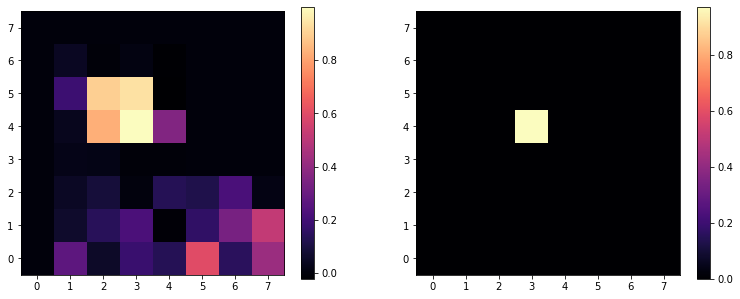

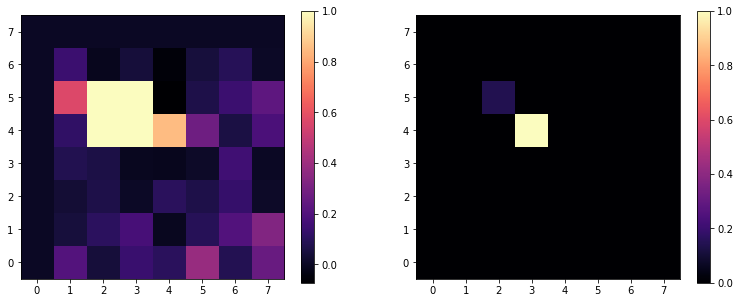

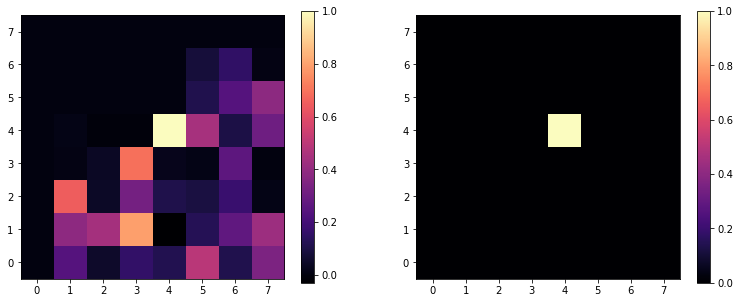

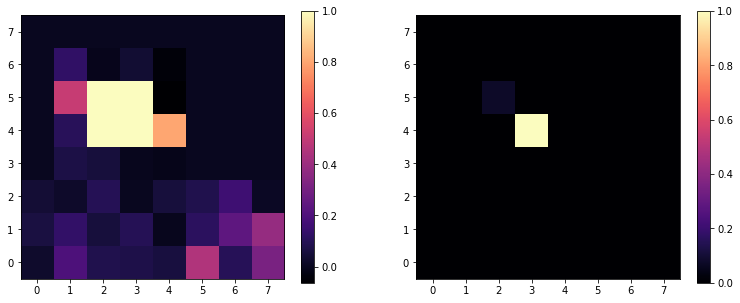

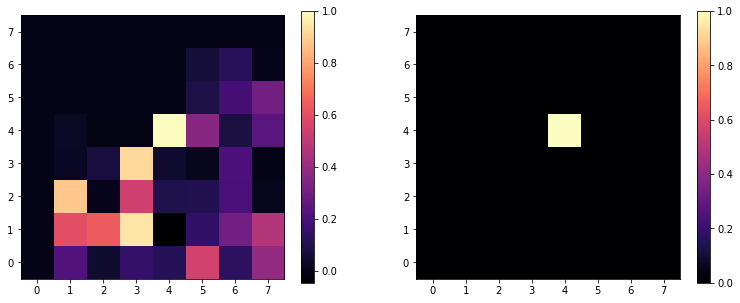

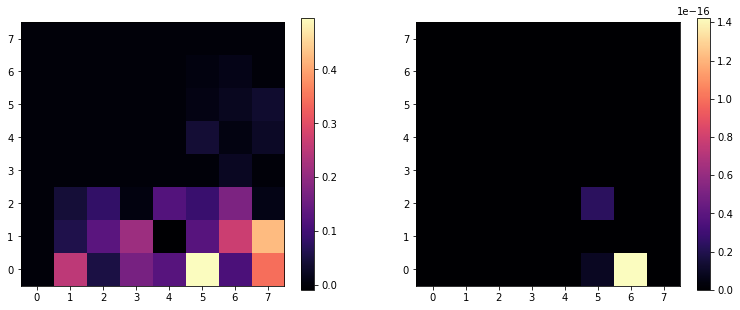

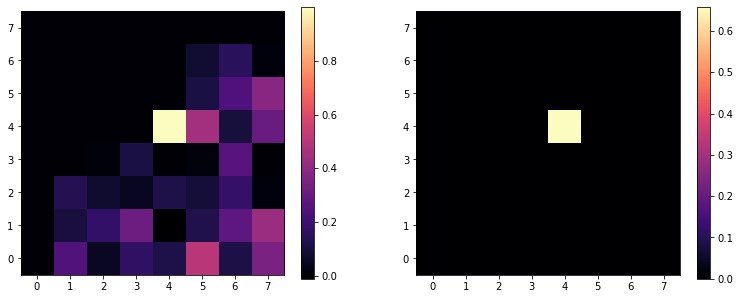

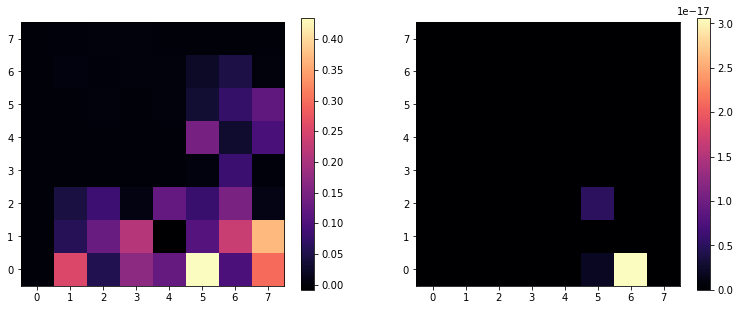

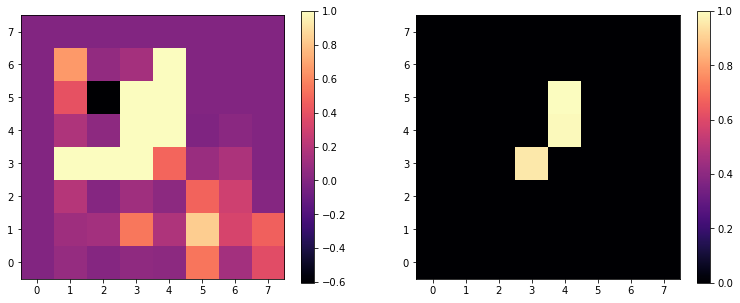

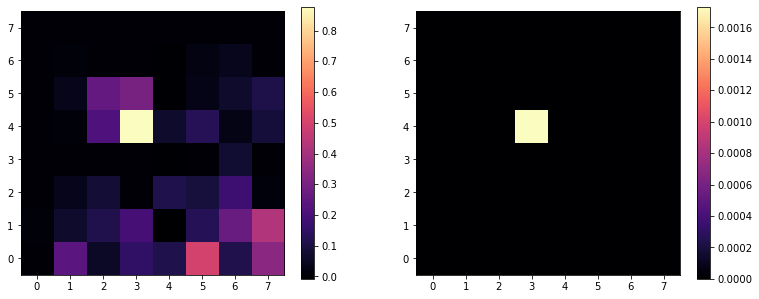

In [57]:
xb = torch.randn(batch_size, latent_size, 1, 1, device=device) 
test = generator(xb)
for i in range(10):
    fig, (QAx, TAx) = plt.subplots(nrows=1, ncols=2, figsize= (13,5))

    QPlot = QAx.imshow(np.power(test[i, 0].detach().cpu().T,1), cmap=colormap);    
    QAx.invert_yaxis()
    QAx.set_xticks(np.arange(0,8))
    Qcbar = plt.colorbar(QPlot, ax=QAx)
    
    TPlot = TAx.imshow(np.power(test[i, 1].detach().cpu().T,10), cmap=colormap);    
    TAx.invert_yaxis()
    TAx.set_xticks(np.arange(0,8))
    Tcbar = plt.colorbar(TPlot, ax=TAx)

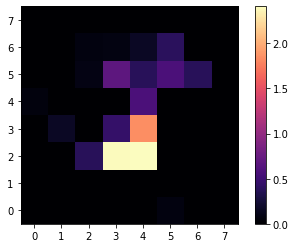

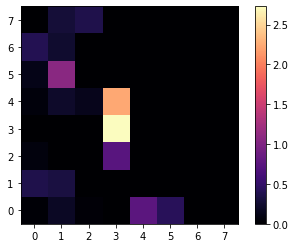

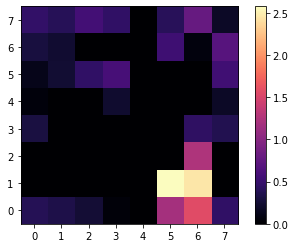

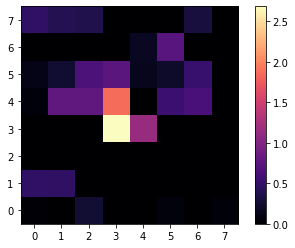

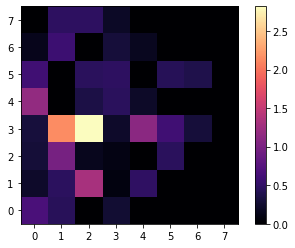

In [58]:
for i in range(5):
    fig, ax = plt.subplots()
    plt.imshow(QTDC[i, 0].detach().cpu().T, cmap=colormap)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0,8))
    plt.colorbar()
    plt.show()

In [59]:
# for i in range(5):
#     plotEvent(raw_data, i)

In [60]:
losses_g, losses_d, real_scores, fake_scores = history

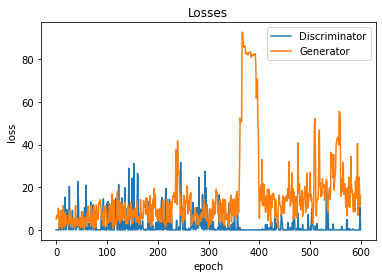

In [61]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

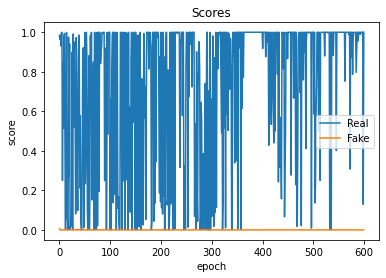

In [62]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');